# Install Dependencies and Setup

In [39]:
import tensorflow as tf
import os
import cv2
import imghdr
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras import regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [40]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [41]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# Load Data

In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
dataset = '/content/drive/MyDrive/kuliah/Kapita Selekta/Dataset'

In [44]:
train = os.path.join(dataset, 'train')
test = os.path.join(dataset, 'test')

In [45]:
def count_images_in_folder(folder_path):
    count = 0
    for root, dirs, files in os.walk(folder_path):
        count += len(files)
    return count

# Train paths
train_melengkung = os.path.join(train, 'melengkung')
train_menjari = os.path.join(train, 'menjari')
train_menyirip = os.path.join(train, 'menyirip')
train_sejajar = os.path.join(train, 'sejajar')

# Test paths
test_melengkung = os.path.join(test, 'melengkung')
test_menjari = os.path.join(test, 'menjari')
test_menyirip = os.path.join(test, 'menyirip')
test_sejajar = os.path.join(test, 'sejajar')

# Count images
total_melengkung_train = count_images_in_folder(train_melengkung)
total_menjari_train = count_images_in_folder(train_menjari)
total_menyirip_train = count_images_in_folder(train_menyirip)
total_sejajar_train = count_images_in_folder(train_sejajar)

total_melengkung_test = count_images_in_folder(test_melengkung)
total_menjari_test = count_images_in_folder(test_menjari)
total_menyirip_test = count_images_in_folder(test_menyirip)
total_sejajar_test = count_images_in_folder(test_sejajar)

# Calculate total
total_train = total_melengkung_train + total_menjari_train + total_menyirip_train + total_sejajar_train
total_test = total_melengkung_test + total_menjari_test + total_menyirip_test + total_sejajar_test

# Print results
print('total training melengkung images          : ', total_melengkung_train)
print('total training menjari images             : ', total_menjari_train)
print('total training menyirip images            : ', total_menyirip_train)
print('total training sejajar images             : ', total_sejajar_train)

print('total test melengkung images              : ', total_melengkung_test)
print('total test menjari images                 : ', total_menjari_test)
print('total test menyirip images                : ', total_menyirip_test)
print('total test sejajar images                 : ', total_sejajar_test)

print('\n---------------------------------------------\n')
print('total training images             : ', total_train)
print('total test images                 : ', total_test)


total training melengkung images          :  360
total training menjari images             :  360
total training menyirip images            :  360
total training sejajar images             :  360
total test melengkung images              :  90
total test menjari images                 :  90
total test menyirip images                :  90
total test sejajar images                 :  90

---------------------------------------------

total training images             :  1440
total test images                 :  360


In [66]:
batch_size = 64
epochs = 10
img_height = 224
img_width = 224

# Data Augmentation

In [67]:
train_augemnt = ImageDataGenerator(
                    rescale=1./255.0,
                    featurewise_center=True,
                    rotation_range=60,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    fill_mode='nearest'
                    )
test_augment = ImageDataGenerator(
                    rescale=1./255.0,
                    featurewise_center=True,
                    rotation_range=60,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    shear_range=0.2,
                    fill_mode='nearest'
                    )

# Train Dataset

In [68]:
train_data = train_augemnt.flow_from_directory(batch_size=batch_size,
                                               directory=train,
                                               shuffle=True,
                                               target_size=(img_height, img_width),
                                               class_mode='categorical')

Found 1440 images belonging to 4 classes.


 # Test Dataset

In [69]:
test_data = test_augment.flow_from_directory(batch_size=batch_size,
                                             directory=test,
                                             target_size=(img_height, img_width),
                                             class_mode='categorical')

Found 360 images belonging to 4 classes.


# Visualize training images

In [70]:
sample_training_images, _ = next(train_data)

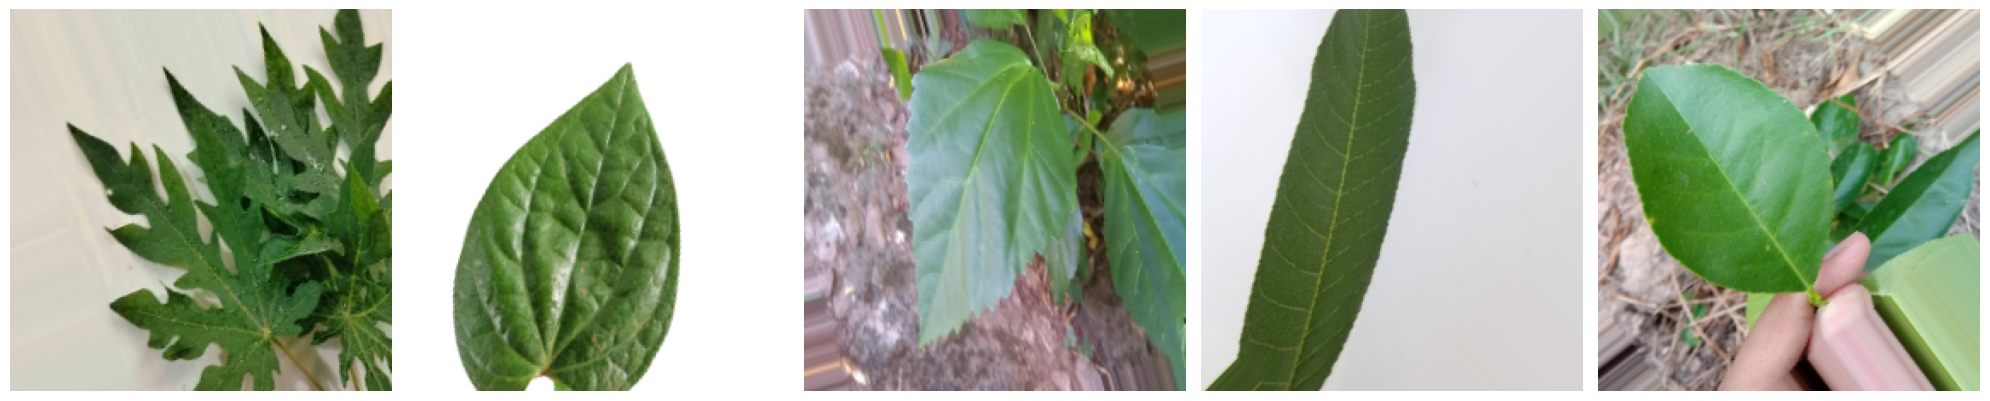

In [71]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(sample_training_images[:5])

# Class

In [72]:
print(f"Class indices for train data {train_data.class_indices}")
print(f"Class indices for test data {test_data.class_indices}")

Class indices for train data {'melengkung': 0, 'menjari': 1, 'menyirip': 2, 'sejajar': 3}
Class indices for test data {'melengkung': 0, 'menjari': 1, 'menyirip': 2, 'sejajar': 3}


# Build Model

In [73]:
base_model = InceptionResNetV2(
        input_shape=(img_height, img_width, 3),
        include_top=False,
        weights='imagenet',
        pooling='avg'
    )

In [74]:
layer = tf.keras.layers.Dropout(0.2)(base_model.output)
layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01))(layer)
layer = tf.keras.layers.Dropout(0.2)(layer)
layer = tf.keras.layers.Dense(units=4, activation='softmax')(layer)

model = tf.keras.Model( base_model.input, layer)

In [75]:
model.compile(
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999),
        loss = ['categorical_crossentropy'],
        metrics = ['accuracy']
    )

In [76]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_609 (Conv2D)         (None, 111, 111, 32)         864       ['input_4[0][0]']             
                                                                                                  
 batch_normalization_609 (B  (None, 111, 111, 32)         96        ['conv2d_609[0][0]']          
 atchNormalization)                                                                               
                                                                                                  
 activation_609 (Activation  (None, 111, 111, 32)         0         ['batch_normalization_60

In [77]:
callback = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        min_delta=0.001,
        patience=5,
        verbose=1,
        mode='auto'
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_accuracy',
        patience=1,
        verbose=1,
        factor=0.25,
        min_lr=0.000003
    ),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='checkpoint.h5',
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

history = model.fit(
    train_data,
    steps_per_epoch=total_train // batch_size,
    epochs=epochs,
    validation_data=test_data,
    validation_steps=total_test // batch_size,
    callbacks=[callback]
)

Epoch 1/10
22/22 [==============================] - ETA: 0s - loss: 2.7302 - accuracy: 0.7013
Epoch 1: val_accuracy improved from -inf to 0.83438, saving model to checkpoint.h5
22/22 [==============================] - 188s 4s/step - loss: 2.7302 - accuracy: 0.7013 - val_loss: 2.2374 - val_accuracy: 0.8344 - lr: 1.0000e-04
Epoch 2/10
22/22 [==============================] - ETA: 0s - loss: 1.9978 - accuracy: 0.9608
Epoch 2: val_accuracy improved from 0.83438 to 0.97188, saving model to checkpoint.h5
22/22 [==============================] - 87s 4s/step - loss: 1.9978 - accuracy: 0.9608 - val_loss: 1.8972 - val_accuracy: 0.9719 - lr: 1.0000e-04
Epoch 3/10
22/22 [==============================] - ETA: 0s - loss: 1.8113 - accuracy: 0.9906
Epoch 3: ReduceLROnPlateau reducing learning rate to 2.499999936844688e-05.

Epoch 3: val_accuracy did not improve from 0.97188
22/22 [==============================] - 92s 4s/step - loss: 1.8113 - accuracy: 0.9906 - val_loss: 1.9155 - val_accuracy: 0.9719

# Visualize training result

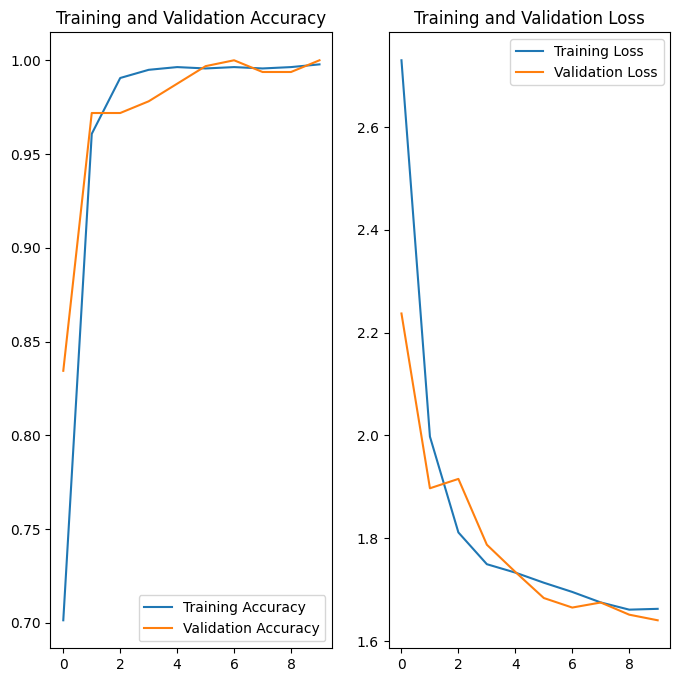

In [78]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss=history.history['loss']
val_loss=history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


 # Evaluate & Test

In [95]:
loss, accuracy = model.evaluate(test_data)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

image_path = '/content/daun sirih 2.jpg'

img_height = 224
img_width = 224

image = tf.keras.preprocessing.image.load_img(image_path, target_size=(img_height, img_width))
image_array = tf.keras.preprocessing.image.img_to_array(image)
image_array = image_array / 255.0
image_array = np.expand_dims(image_array, axis=0)

predictions = model.predict(image_array)
predicted_class_index = np.argmax(predictions[0])
class_labels = ['melengkung', 'menjari', 'menyirip', 'sejajar']
predicted_class = class_labels[predicted_class_index]

print('Predicted Class:', predicted_class)


6/6 [==============================] - 15s 3s/step - loss: 1.6444 - accuracy: 1.0000
Test Loss: 1.6443506479263306
Test Accuracy: 1.0
1/1 [==============================] - 0s 39ms/step
Predicted Class: melengkung


# Saved Model

In [97]:
model.save(os.path.join('models','model_kapita.h5'))

In [98]:
new_model = load_model('/content/models/model_kapita.h5')

In [99]:
img = cv2.imread(image_path)
resize = tf.image.resize(img, (224,224))
new_model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 4s 4s/step


array([[9.9905747e-01, 5.9020043e-05, 6.0454680e-04, 2.7890917e-04]],
      dtype=float32)